In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import json
from pathlib import Path
from geodatasets import get_path
import contextily as ctx
from shapely.geometry import box
import sys
# src_path = Path(__file__).resolve().parent.parent
base = Path.cwd().parent
src_path = base
sys.path.append(str(src_path))
from utils import (
    ensure_plots_dir
)

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*DataFrame.swapaxes.*"
)

# CitiBike Rasterization Results Visualization

This notebook loads the rasterized CitiBike and crash data and reproduces the analysis and visualizations from the rasterization_testing notebook.

We will:
1. Load the processed 3D arrays (citibike voxel visits, crashes)
2. Calculate temporal and spatial aggregations
3. Visualize risk patterns by day of week and time of day
4. Create spatial heatmaps with NYC borough overlays

In [ ]:
# Global configuration
SAVE_PLOTS = True  # Set to False to disable saving plots
MIN_CRASHES_THRESHOLD = 3  # Zero out voxels with N or fewer crashes per year for reliable statistics
MIN_VOXEL_VISITS_THRESHOLD = 100  # Zero out voxels with N or fewer voxel visits per year for reliable statistics

# Adjustment factor for estimating total bike voxel visits from observed voxel visits
PERCENTAGE_OF_TOTAL_VOXEL_VISITS = 0.39  # Observed voxel visits represent ~39% of total voxel visits
VOXEL_VISIT_ESTIMATION_FACTOR = 1 / PERCENTAGE_OF_TOTAL_VOXEL_VISITS  # Factor to estimate total voxel visits from observed voxel visits

In [3]:
# Configuration - Update this path to your results directory
# Default assumes 800m x 800m x 6h grid
results_dir = "/home/lennartz/repos/citi-bike/results/cellx800m_celly800m_cellt6h"

# Create plots directory
plots_dir = ensure_plots_dir(results_dir)

# Load the rasterized data
print("Loading rasterized data...")
citibike_counts = np.load(f"{results_dir}/citibike_counts.npy")
crash_counts = np.load(f"{results_dir}/crash_counts.npy")

# Load metadata
with open(f"{results_dir}/metadata.json", 'r') as f:
    metadata = json.load(f)

print(f"Grid dimensions: {citibike_counts.shape}")
print(f"Total voxel visits from CitiBike: {citibike_counts.sum():,}")
print(f"Total crashes: {crash_counts.sum():,}")
print(f"Parameters: {metadata['cell_x']}m x {metadata['cell_y']}m x {metadata['cell_t']}h")
print(f"Plots will be saved to: {plots_dir}" if SAVE_PLOTS else "Plot saving disabled")
print(f"Statistical filtering: voxels with ≤{MIN_CRASHES_THRESHOLD} crashes/year OR ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year will be zeroed")

Loading rasterized data...
Grid dimensions: (1460, 92, 98)
Total voxel visits from CitiBike: 101,781,261
Total crashes: 4,858
Parameters: 800.0m x 800.0m x 6.0h
Plots will be saved to: /home/lennartz/repos/citi-bike/results/cellx800m_celly800m_cellt6h/plots
Statistical filtering: voxels with ≤3 crashes/year OR ≤100 voxel visits/year will be zeroed


In [4]:
# Calculate aggregated data (reproducing from rasterization_testing)
print("Calculating aggregations...")

# Aggregate over time and space
voxel_visits_time_aggregated = citibike_counts.sum(0).astype(np.float32)
voxel_visits_spatial_aggregated = citibike_counts.sum((1,2)).astype(np.float32)
crashes_time_aggregated = crash_counts.sum(0).astype(np.float32)
crashes_spatial_aggregated = crash_counts.sum((1,2)).astype(np.float32)

# Estimate total voxel visits from observed voxel visits
estimated_voxel_visits_time_aggregated = voxel_visits_time_aggregated * VOXEL_VISIT_ESTIMATION_FACTOR
estimated_voxel_visits_spatial_aggregated = voxel_visits_spatial_aggregated * VOXEL_VISIT_ESTIMATION_FACTOR

# Normalize (crashes per estimated total voxel visit)
time_aggregated_normalized = np.nan_to_num(
    crashes_time_aggregated / estimated_voxel_visits_time_aggregated,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)

space_aggregated_normalized = np.nan_to_num(
    crashes_spatial_aggregated / estimated_voxel_visits_spatial_aggregated,
    nan=0.0,
    posinf=0.0,
    neginf=0.0
)

print(f"Spatial aggregated shape: {voxel_visits_spatial_aggregated.shape}")
print(f"Time aggregated shape: {voxel_visits_time_aggregated.shape}")
print(f"Voxel visit estimation factor: {VOXEL_VISIT_ESTIMATION_FACTOR:.2f} (observed voxel visits = {PERCENTAGE_OF_TOTAL_VOXEL_VISITS:.0%} of total)")
print(f"Risk now represents crashes per estimated total voxel visit")

Calculating aggregations...
Spatial aggregated shape: (1460,)
Time aggregated shape: (92, 98)
Voxel visit estimation factor: 2.56 (observed voxel visits = 39% of total)
Risk now represents crashes per estimated total voxel visit


/tmp/ipykernel_1390955/3909013412.py:16: RuntimeWarning: divide by zero encountered in divide
  crashes_time_aggregated / estimated_voxel_visits_time_aggregated,
/tmp/ipykernel_1390955/3909013412.py:16: RuntimeWarning: invalid value encountered in divide
  crashes_time_aggregated / estimated_voxel_visits_time_aggregated,


## Day of Week and Time of Day Analysis

Let's analyze crash risk patterns by day of week and 6-hour time chunks, reproducing the analysis from the rasterization_testing notebook.

Plot saved: crash_risk_by_day_and_time_800.0m_800.0m_6.0h.png


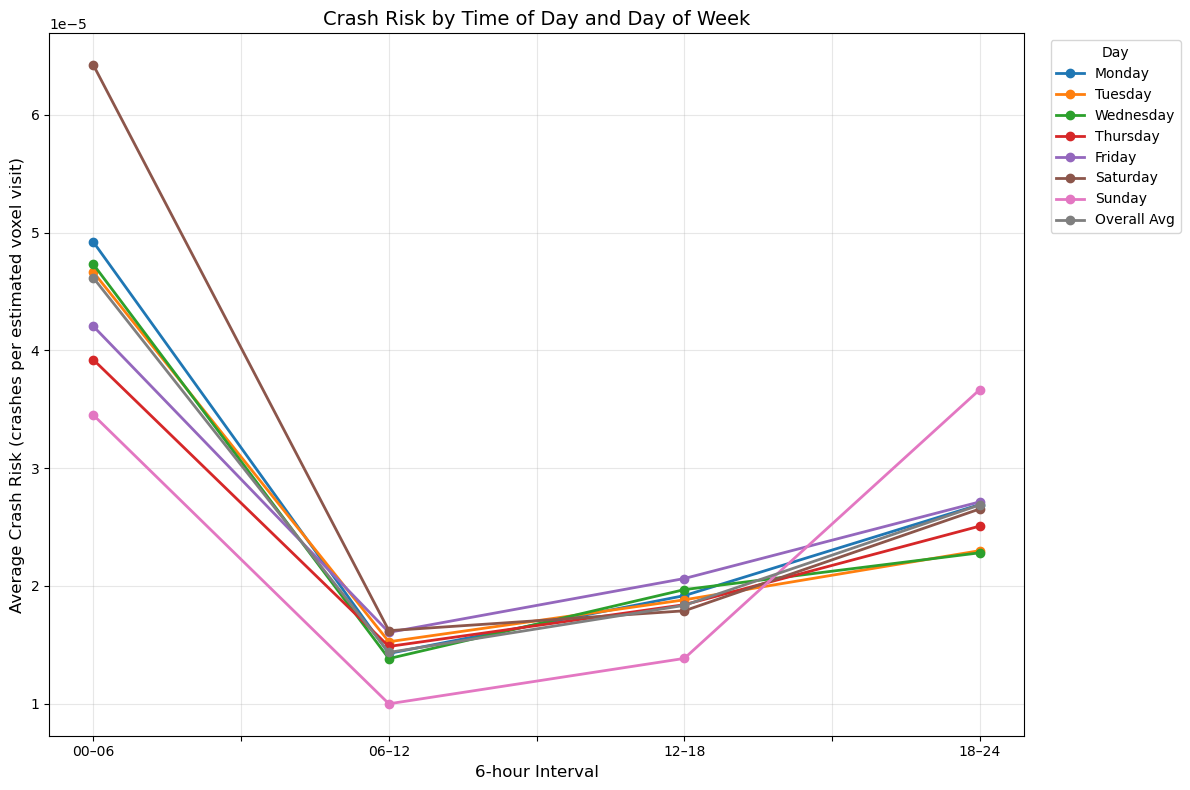

Risk patterns by day and time:
         Monday   Tuesday  Wednesday  Thursday    Friday  Saturday    Sunday  \
00–06  0.000049  0.000047   0.000047  0.000039  0.000042  0.000064  0.000034   
06–12  0.000014  0.000015   0.000014  0.000015  0.000016  0.000016  0.000010   
12–18  0.000019  0.000019   0.000020  0.000018  0.000021  0.000018  0.000014   
18–24  0.000027  0.000023   0.000023  0.000025  0.000027  0.000027  0.000037   

       Overall Avg  
00–06     0.000046  
06–12     0.000014  
12–18     0.000018  
18–24     0.000027  


In [5]:
# Day of week and time chunk analysis (reproducing from rasterization_testing)
arr = space_aggregated_normalized  # 1-D, length Nt = number of 6 h bins
ref = pd.Timestamp(metadata['reference_time'])

Nt = arr.size
times = ref + pd.to_timedelta(np.arange(Nt) * metadata['cell_t'], unit='h')
chunks = (np.arange(Nt) % 4) + 1        # 1–4 (6-hour chunks)
dows = times.dayofweek                  # 0=Mon…6=Sun

# Build DataFrame and pivot
df = pd.DataFrame({
    'chunk': chunks,
    'dow': dows,
    'value': arr
})
pivot = df.groupby(['chunk','dow'])['value'].mean().unstack()
pivot.columns = [calendar.day_name[d] for d in pivot.columns]

# Rename chunk index to intervals
interval_labels = ["00–06", "06–12", "12–18", "18–24"]
pivot.index = interval_labels

# Add overall average across weekdays
pivot['Overall Avg'] = pivot.mean(axis=1)

# Plot everything
fig, ax = plt.subplots(figsize=(12, 8))
pivot.plot(marker='o', ax=ax, linewidth=2, markersize=6)
ax.set_xlabel("6-hour Interval", fontsize=12)
ax.set_ylabel("Average Crash Risk (crashes per estimated voxel visit)", fontsize=12)
ax.set_title("Crash Risk by Time of Day and Day of Week", fontsize=14)
ax.legend(title="Day", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot if enabled
if SAVE_PLOTS:
    plot_filename = f"crash_risk_by_day_and_time_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

print("Risk patterns by day and time:")
print(pivot)

## Spatial Risk Heatmap with NYC Borough Overlay

Now let's create the spatial heatmap showing crash risk across NYC with borough boundaries overlaid, reproducing the spatial visualization from the rasterization_testing notebook.

Statistical filtering:
  8,574 cells filtered for ≤3 crashes/year (95.1%)
  8,297 cells filtered for ≤100 voxel visits/year (92.0%)
  8,673 cells filtered overall (96.2%)


Plot saved: spatial_risk_heatmap_800.0m_800.0m_6.0h_filtered.png


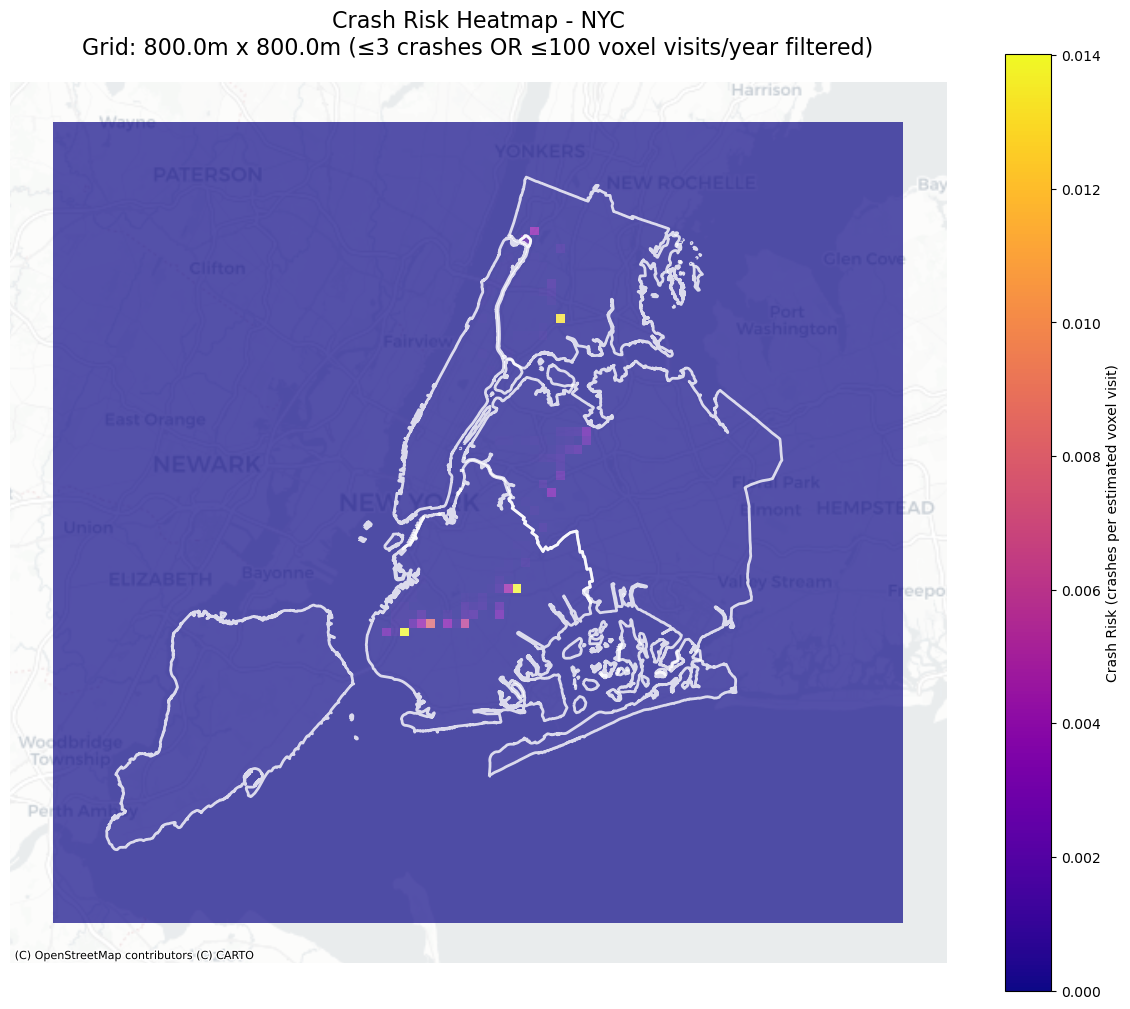

Risk statistics (before filtering):
  Min risk: 0.000000
  Max risk: 2.730000
  Mean risk: 0.010228
  Std risk: 0.082376
Risk statistics (after filtering ≤3 crashes OR ≤100 voxel visits/year):
  Min risk: 0.000000
  Max risk: 0.014006
  Mean risk (non-zero): 0.000317
  Std risk (non-zero): 0.001448
  Non-zero cells: 343 / 9,016


In [6]:
# Create spatial heatmap with NYC borough overlay (reproducing from rasterization_testing)
normed = time_aggregated_normalized  # shape (Ny, Nx)
lon_min, lon_max = metadata['lon_min'], metadata['lon_max']
lat_min, lat_max = metadata['lat_min'], metadata['lat_max']

# Apply statistical filtering: zero out voxels with too few crashes OR voxel visits for reliable estimates
normed_filtered = normed.copy()
crashes_spatial = crash_counts.sum(0)  # Sum over time to get total crashes per spatial cell
voxel_visits_spatial = citibike_counts.sum(0)  # Sum over time to get total voxel visits per spatial cell

low_crash_mask = crashes_spatial <= MIN_CRASHES_THRESHOLD
low_voxel_visits_mask = voxel_visits_spatial <= MIN_VOXEL_VISITS_THRESHOLD
combined_filter_mask = low_crash_mask | low_voxel_visits_mask  # Filter if EITHER condition is true

normed_filtered[combined_filter_mask] = 0

# Report filtering statistics
crash_filtered = np.sum(low_crash_mask)
voxel_visits_filtered = np.sum(low_voxel_visits_mask)
total_filtered = np.sum(combined_filter_mask)
total_cells = combined_filter_mask.size

print(f"Statistical filtering:")
print(f"  {crash_filtered:,} cells filtered for ≤{MIN_CRASHES_THRESHOLD} crashes/year ({100*crash_filtered/total_cells:.1f}%)")
print(f"  {voxel_visits_filtered:,} cells filtered for ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year ({100*voxel_visits_filtered/total_cells:.1f}%)")
print(f"  {total_filtered:,} cells filtered overall ({100*total_filtered/total_cells:.1f}%)")

# Build grid-cell polygons & values
nrows, ncols = normed_filtered.shape
lon_edges = np.linspace(lon_min, lon_max, ncols+1)
lat_edges = np.linspace(lat_min, lat_max, nrows+1)

cells, vals = [], []
for j in range(nrows):
    for i in range(ncols):
        cells.append(
            box(
                lon_edges[i],   lat_edges[j],
                lon_edges[i+1], lat_edges[j+1]
            )
        )
        vals.append(normed_filtered[j, i])

grid_gdf = gpd.GeoDataFrame(
    {'crash_risk': vals},
    geometry=cells,
    crs="EPSG:4326"
)

# Reproject to Web Mercator
grid_gdf = grid_gdf.to_crs(epsg=3857)

# Load and reproject borough outlines
nybb = gpd.read_file(get_path("nybb")).to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the grid with crash risk values
grid_gdf.plot(
    ax=ax,
    column='crash_risk',
    cmap="plasma",
    alpha=0.7,
    linewidth=0,
    legend=True,
    legend_kwds={'label': 'Crash Risk (crashes per estimated voxel visit)', 'shrink': 0.8}
)

# Add borough boundaries
nybb.boundary.plot(ax=ax, linewidth=2, edgecolor='white', alpha=0.8)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=grid_gdf.crs,
    alpha=0.5
)

title = f"Crash Risk Heatmap - NYC\nGrid: {metadata['cell_x']}m x {metadata['cell_y']}m"
title += f" (≤{MIN_CRASHES_THRESHOLD} crashes OR ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year filtered)"
ax.set_title(title, fontsize=16, pad=20)
ax.set_axis_off()
plt.tight_layout()

# Save plot if enabled
if SAVE_PLOTS:
    plot_filename = f"spatial_risk_heatmap_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h_filtered.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

print(f"Risk statistics (before filtering):")
print(f"  Min risk: {normed.min():.6f}")
print(f"  Max risk: {normed.max():.6f}")
print(f"  Mean risk: {normed.mean():.6f}")
print(f"  Std risk: {normed.std():.6f}")

print(f"Risk statistics (after filtering ≤{MIN_CRASHES_THRESHOLD} crashes OR ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year):")
print(f"  Min risk: {normed_filtered.min():.6f}")
print(f"  Max risk: {normed_filtered.max():.6f}")
print(f"  Mean risk (non-zero): {normed_filtered[normed_filtered > 0].mean():.6f}")
print(f"  Std risk (non-zero): {normed_filtered[normed_filtered > 0].std():.6f}")
print(f"  Non-zero cells: {np.count_nonzero(normed_filtered):,} / {normed_filtered.size:,}")

## Monthly Risk Analysis with Interactive Visualization

Let's analyze how crash risk patterns evolve throughout the year by aggregating data monthly and creating an interactive visualization.

In [7]:
# Monthly Analysis - Aggregate voxel visits and crashes by month
print("Calculating monthly aggregations...")

# Get reference time info
ref = pd.Timestamp(metadata['reference_time'])
cell_t = metadata['cell_t']  # hours per time step
Nt, Ny, Nx = citibike_counts.shape

# Create time stamps for each time step
times = ref + pd.to_timedelta(np.arange(Nt) * cell_t, unit='h')
months = times.month

# Initialize monthly arrays
monthly_voxel_visits = np.zeros((12, Ny, Nx), dtype=np.float32)
monthly_crashes = np.zeros((12, Ny, Nx), dtype=np.float32)

# Aggregate by month (1-12)
for month in range(1, 13):
    month_mask = months == month
    monthly_voxel_visits[month-1] = citibike_counts[month_mask].sum(0)
    monthly_crashes[month-1] = crash_counts[month_mask].sum(0)

print(f"Monthly aggregation complete. Shape: {monthly_voxel_visits.shape}")

# Apply same statistical filtering: use yearly crash AND voxel visit counts for filtering
yearly_crashes = crash_counts.sum(0)  # Total crashes per spatial cell
yearly_voxel_visits = citibike_counts.sum(0)  # Total voxel visits per spatial cell

crash_filter_mask = yearly_crashes <= MIN_CRASHES_THRESHOLD
voxel_visits_filter_mask = yearly_voxel_visits <= MIN_VOXEL_VISITS_THRESHOLD
combined_filter_mask = crash_filter_mask | voxel_visits_filter_mask

# Calculate monthly normalized risk
monthly_risk = np.zeros_like(monthly_voxel_visits)
for month in range(12):
    # Estimate total voxel visits for this month
    estimated_monthly_voxel_visits = monthly_voxel_visits[month] * VOXEL_VISIT_ESTIMATION_FACTOR
    # Calculate risk for this month
    month_risk = np.nan_to_num(
        monthly_crashes[month] / estimated_monthly_voxel_visits,
        nan=0.0, posinf=0.0, neginf=0.0
    )
    # Apply combined yearly filter
    month_risk[combined_filter_mask] = 0.0
    monthly_risk[month] = month_risk

# Calculate basic monthly statistics (excluding filtered metrics)
monthly_stats = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in range(12):
    stats = {
        'month': month_names[month],
        'voxel_visits': monthly_voxel_visits[month].sum(),
        'crashes': monthly_crashes[month].sum()
    }
    monthly_stats.append(stats)

# Display monthly statistics (excluding misleading filtered metrics)
print("\nMonthly Voxel Visit and Crash Statistics:")
print("Month | Voxel Visits | Crashes")
print("-" * 35)
for stats in monthly_stats:
    print(f"{stats['month']:>5} | {stats['voxel_visits']:>11.0f} | {stats['crashes']:>7.0f}")

# Report filtering statistics
crash_filtered = np.sum(crash_filter_mask)
voxel_visits_filtered = np.sum(voxel_visits_filter_mask)
total_filtered = np.sum(combined_filter_mask)
total_cells = combined_filter_mask.size

print(f"\nFiltering Summary:")
print(f"  Cells with ≤{MIN_CRASHES_THRESHOLD} crashes/year: {crash_filtered:,}")
print(f"  Cells with ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year: {voxel_visits_filtered:,}")
print(f"  Total filtered cells: {total_filtered:,} out of {total_cells:,} ({100*total_filtered/total_cells:.1f}%)")
print("\nNote: Monthly risk statistics are not shown as they're affected by yearly filtering criteria.")

Calculating monthly aggregations...
Monthly aggregation complete. Shape: (12, 92, 98)

Monthly Voxel Visit and Crash Statistics:
Month | Voxel Visits | Crashes
-----------------------------------
  Jan |     4726615 |     233
  Feb |     4504548 |     239
  Mar |     5668470 |     351
  Apr |     7832992 |     383
  May |     9942805 |     479
  Jun |    10042054 |     461
  Jul |    10892539 |     499
  Aug |    12148703 |     502
  Sep |    10406514 |     508
  Oct |    11243646 |     491
  Nov |     8238669 |     378
  Dec |     6133706 |     334

Filtering Summary:
  Cells with ≤3 crashes/year: 8,574
  Cells with ≤100 voxel visits/year: 8,297
  Total filtered cells: 8,673 out of 9,016 (96.2%)

Note: Monthly risk statistics are not shown as they're affected by yearly filtering criteria.


/tmp/ipykernel_1390955/1953171150.py:40: RuntimeWarning: divide by zero encountered in divide
  monthly_crashes[month] / estimated_monthly_voxel_visits,
/tmp/ipykernel_1390955/1953171150.py:40: RuntimeWarning: invalid value encountered in divide
  monthly_crashes[month] / estimated_monthly_voxel_visits,


/tmp/ipykernel_1390955/2860078347.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved: monthly_risk_evolution_800.0m_800.0m_6.0h.png


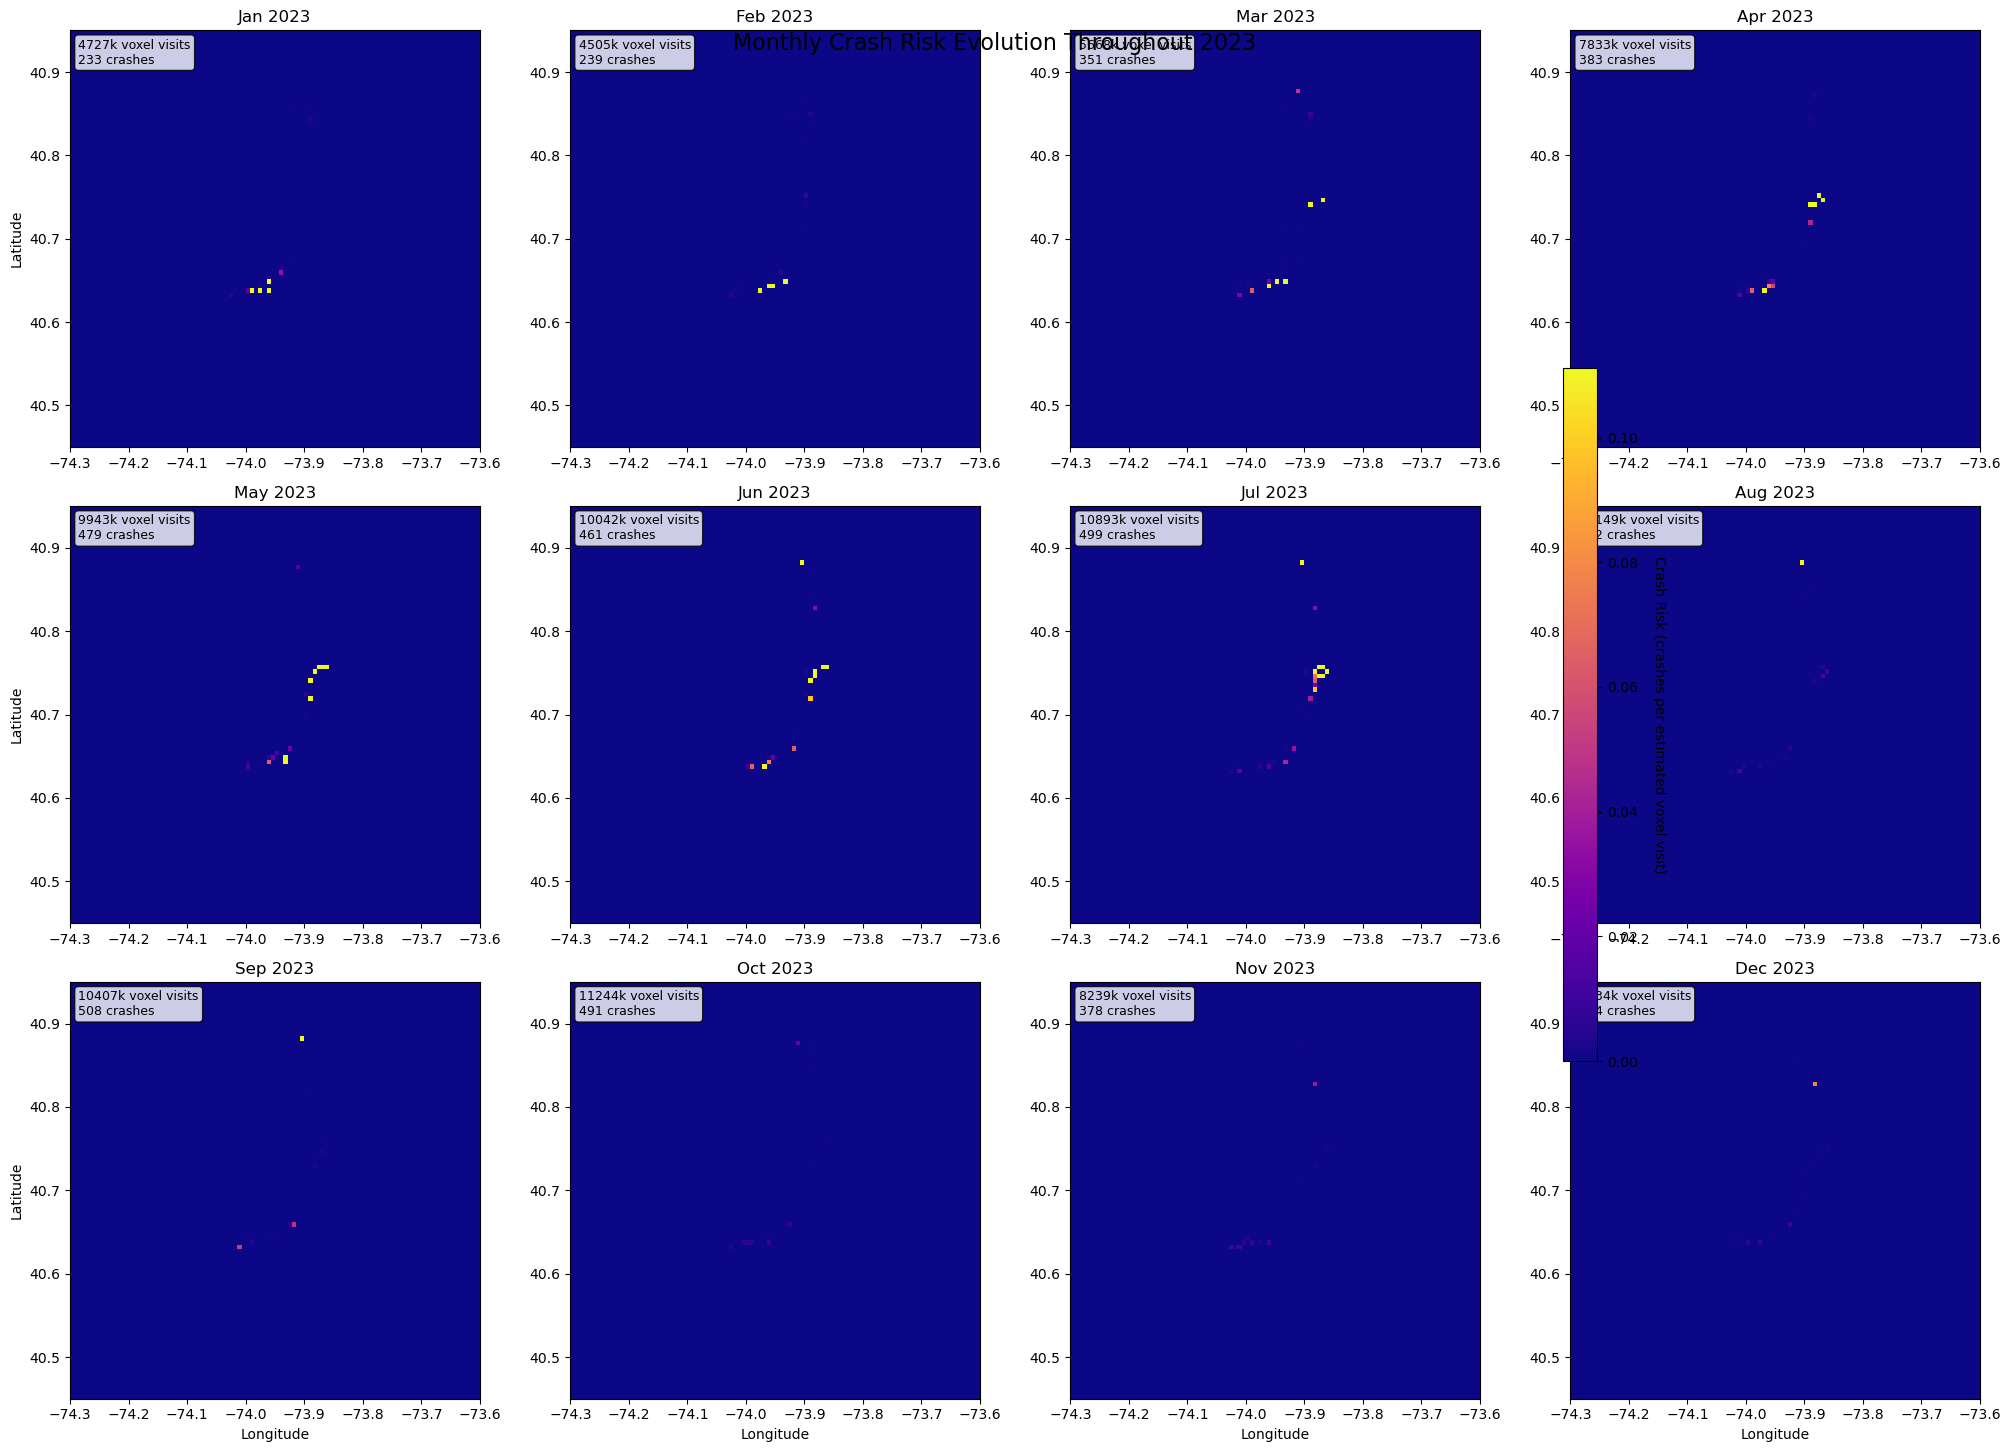

Plot saved: seasonal_risk_comparison_800.0m_800.0m_6.0h.png


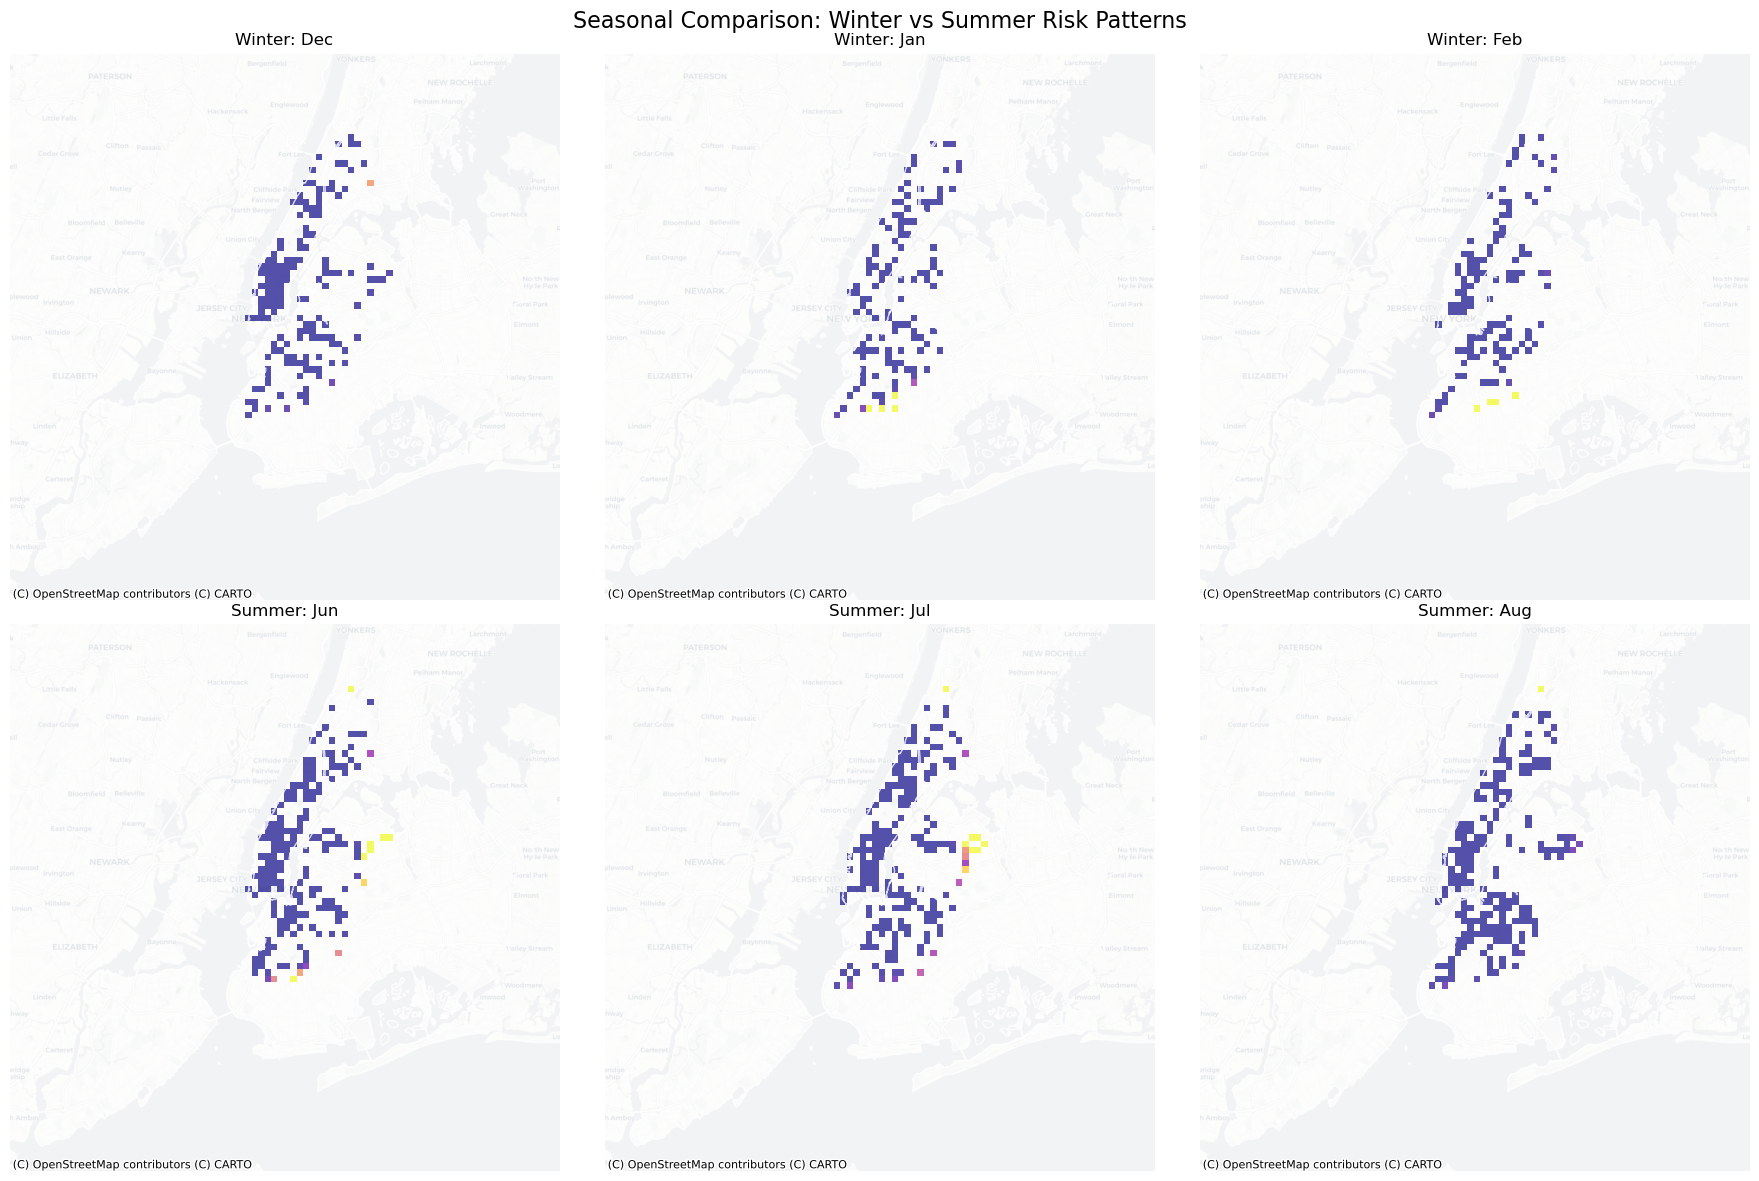

In [8]:
# Create Interactive Monthly Risk Visualization
from matplotlib.widgets import Slider
import matplotlib.animation as animation
from IPython.display import HTML

# First create static subplots for all months
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Monthly Crash Risk Evolution Throughout 2023', fontsize=16, y=0.95)

# Prepare geographic data
lon_min, lon_max = metadata['lon_min'], metadata['lon_max']
lat_min, lat_max = metadata['lat_min'], metadata['lat_max']

# Find global min/max for consistent color scale
vmin = 0
vmax = np.percentile(monthly_risk[monthly_risk > 0], 98)  # Use 98th percentile to avoid extreme outliers

for month in range(12):
    row = month // 4
    col = month % 4
    ax = axes[row, col]
    
    # Create the heatmap
    im = ax.imshow(
        np.flipud(monthly_risk[month]), 
        cmap='plasma', 
        aspect='auto',
        vmin=vmin, vmax=vmax,
        extent=[lon_min, lon_max, lat_min, lat_max]
    )
    
    ax.set_title(f'{month_names[month]} 2023', fontsize=12)
    ax.set_xlabel('Longitude' if row == 2 else '')
    ax.set_ylabel('Latitude' if col == 0 else '')
    
    # Add voxel visit and crash counts as text
    voxel_visits_k = monthly_voxel_visits[month].sum() / 1000
    crashes = monthly_crashes[month].sum()
    ax.text(0.02, 0.98, f'{voxel_visits_k:.0f}k voxel visits\n{crashes:.0f} crashes', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=9)

# Add colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.6, aspect=20)
cbar.set_label('Crash Risk (crashes per estimated voxel visit)', rotation=270, labelpad=20)

plt.tight_layout()

# Save the static plot
if SAVE_PLOTS:
    plot_filename = f"monthly_risk_evolution_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

# Create geographic heatmaps with borough overlays for selected months
# Show winter (Dec, Jan, Feb) vs summer (Jun, Jul, Aug) comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Seasonal Comparison: Winter vs Summer Risk Patterns', fontsize=16)

# Define seasons
winter_months = [11, 0, 1]  # Dec, Jan, Feb (0-indexed)
summer_months = [5, 6, 7]   # Jun, Jul, Aug (0-indexed)
seasons = [('Winter', winter_months), ('Summer', summer_months)]

# Load borough boundaries
nybb = gpd.read_file(get_path("nybb")).to_crs(epsg=3857)

for season_idx, (season_name, months) in enumerate(seasons):
    for month_idx, month in enumerate(months):
        ax = axes[season_idx, month_idx]
        
        # Prepare geographic data for this month
        risk_data = monthly_risk[month]
        nrows, ncols = risk_data.shape
        lon_edges = np.linspace(lon_min, lon_max, ncols+1)
        lat_edges = np.linspace(lat_min, lat_max, nrows+1)
        
        # Create grid cells
        cells, vals = [], []
        for j in range(nrows):
            for i in range(ncols):
                if risk_data[j, i] > 0:  # Only include non-zero risk cells
                    cells.append(box(lon_edges[i], lat_edges[j], lon_edges[i+1], lat_edges[j+1]))
                    vals.append(risk_data[j, i])
        
        if cells:  # Only create GeoDataFrame if we have data
            grid_gdf = gpd.GeoDataFrame({'crash_risk': vals}, geometry=cells, crs="EPSG:4326")
            grid_gdf = grid_gdf.to_crs(epsg=3857)
            
            # Plot the risk data
            grid_gdf.plot(
                ax=ax, column='crash_risk', cmap="plasma", alpha=0.7,
                vmin=vmin, vmax=vmax, linewidth=0
            )
        
        # Add borough boundaries
        nybb.boundary.plot(ax=ax, linewidth=1, edgecolor='white', alpha=0.8)
        
        # Add basemap
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, 
                          crs=nybb.crs, alpha=0.3)
        except:
            pass  # Skip basemap if connection fails
        
        ax.set_title(f'{season_name}: {month_names[month]}')
        ax.set_axis_off()

plt.tight_layout()

# Save the seasonal comparison
if SAVE_PLOTS:
    plot_filename = f"seasonal_risk_comparison_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

Plot saved: monthly_trends_800.0m_800.0m_6.0h.png


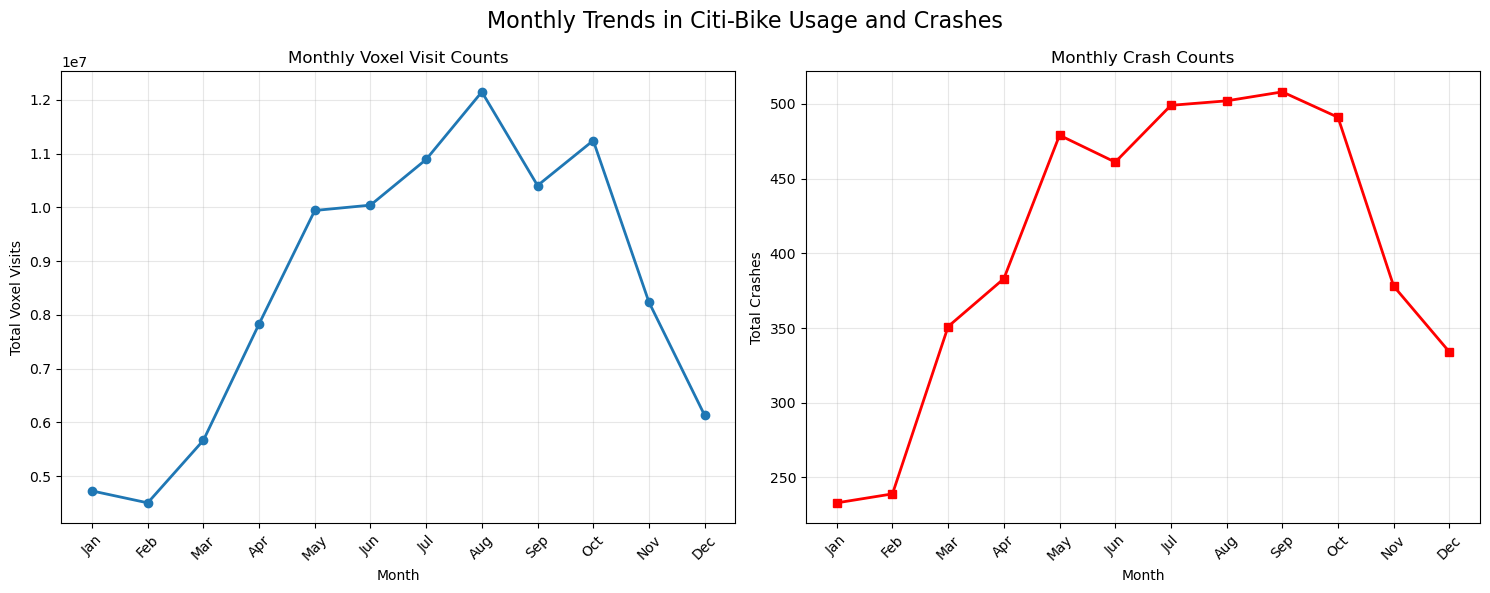

Monthly risk data saved: /home/lennartz/repos/citi-bike/results/cellx800m_celly800m_cellt6h/monthly_risk_data.npy
Monthly statistics saved: /home/lennartz/repos/citi-bike/results/cellx800m_celly800m_cellt6h/monthly_statistics.csv

Monthly Analysis Summary:
• Peak voxel visit month: Aug
• Peak crash month: Sep
• Voxel visit volume variation: 0.32 coefficient of variation
• Crash count variation: 0.25 coefficient of variation


In [9]:
# Analyze monthly trends
monthly_df = pd.DataFrame(monthly_stats)

# Create monthly trend plots (removing misleading mean risk and active cells due to filtering)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Monthly Trends in Citi-Bike Usage and Crashes', fontsize=16)

# Plot 1: Monthly voxel visits
ax1.plot(range(12), monthly_df['voxel_visits'], marker='o', linewidth=2, markersize=6)
ax1.set_title('Monthly Voxel Visit Counts')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Voxel Visits')
ax1.set_xticks(range(12))
ax1.set_xticklabels(month_names, rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly crashes
ax2.plot(range(12), monthly_df['crashes'], marker='s', color='red', linewidth=2, markersize=6)
ax2.set_title('Monthly Crash Counts')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Crashes')
ax2.set_xticks(range(12))
ax2.set_xticklabels(month_names, rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the trends plot
if SAVE_PLOTS:
    plot_filename = f"monthly_trends_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

# Save monthly data for potential interactive visualization
if SAVE_PLOTS:
    monthly_data_output = plots_dir.parent / "monthly_risk_data.npy"
    np.save(monthly_data_output, monthly_risk)
    print(f"Monthly risk data saved: {monthly_data_output}")
    
    # Save monthly statistics as CSV
    monthly_stats_output = plots_dir.parent / "monthly_statistics.csv"
    monthly_df.to_csv(monthly_stats_output, index=False)
    print(f"Monthly statistics saved: {monthly_stats_output}")

print("\nMonthly Analysis Summary:")
print(f"• Peak voxel visit month: {monthly_df.loc[monthly_df['voxel_visits'].idxmax(), 'month']}")
print(f"• Peak crash month: {monthly_df.loc[monthly_df['crashes'].idxmax(), 'month']}")
print(f"• Voxel visit volume variation: {monthly_df['voxel_visits'].std()/monthly_df['voxel_visits'].mean():.2f} coefficient of variation")
print(f"• Crash count variation: {monthly_df['crashes'].std()/monthly_df['crashes'].mean():.2f} coefficient of variation")

## Additional Analysis: Raw Voxel Visit and Crash Counts

Let's also look at the raw counts to understand the data distribution before normalization.

Plot saved: raw_counts_comparison_800.0m_800.0m_6.0h.png


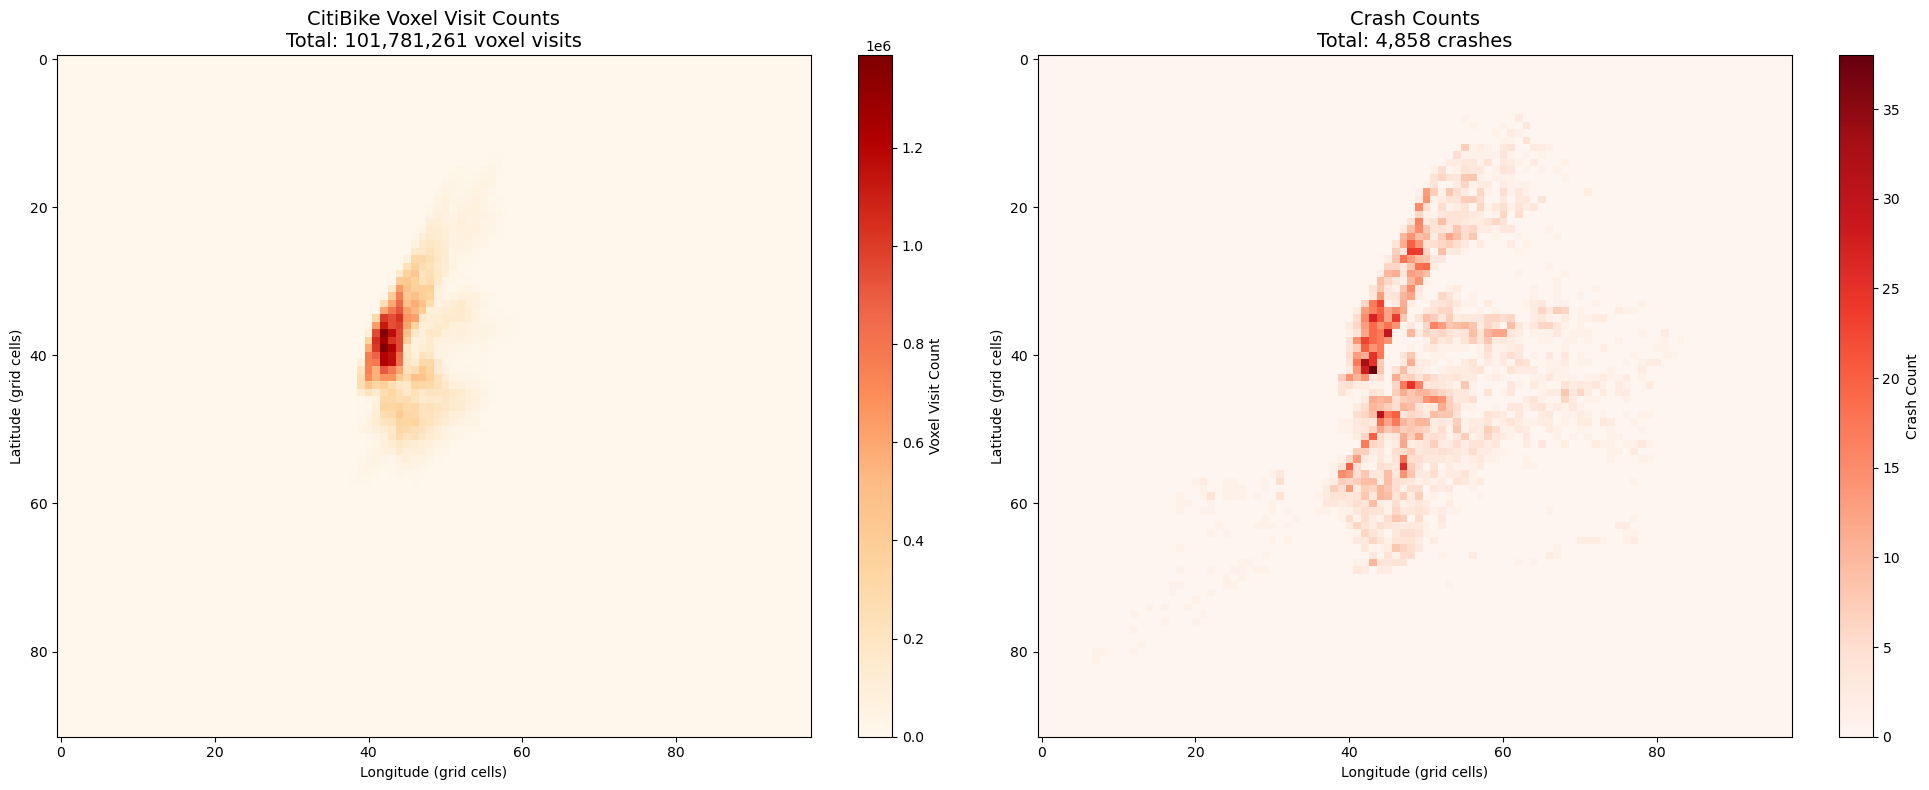

Voxel Visit Statistics:
  Non-zero cells: 2,122 / 9,016
  Max voxel visits in cell: 1,387,731
  Mean voxel visits per non-zero cell: 47964.8

Crash Statistics:
  Non-zero cells: 1,127 / 9,016
  Max crashes in cell: 38
  Mean crashes per non-zero cell: 4.3


In [10]:
# Visualize raw voxel visit counts (flattened spatially, like in rasterization_testing)
voxel_visits_flattened = citibike_counts.sum(0)  # Sum over time dimension

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Voxel visit counts heatmap
im1 = ax1.imshow(np.flipud(voxel_visits_flattened), cmap='OrRd', aspect='auto')
ax1.set_title(f"CitiBike Voxel Visit Counts\nTotal: {citibike_counts.sum():,} voxel visits", fontsize=14)
ax1.set_xlabel("Longitude (grid cells)")
ax1.set_ylabel("Latitude (grid cells)")
plt.colorbar(im1, ax=ax1, label="Voxel Visit Count")

# Crash counts heatmap
crash_flattened = crash_counts.sum(0)  # Sum over time dimension
im2 = ax2.imshow(np.flipud(crash_flattened), cmap='Reds', aspect='auto')
ax2.set_title(f"Crash Counts\nTotal: {crash_counts.sum():,} crashes", fontsize=14)
ax2.set_xlabel("Longitude (grid cells)")
ax2.set_ylabel("Latitude (grid cells)")
plt.colorbar(im2, ax=ax2, label="Crash Count")

plt.tight_layout()

# Save plot if enabled
if SAVE_PLOTS:
    plot_filename = f"raw_counts_comparison_{metadata['cell_x']}m_{metadata['cell_y']}m_{metadata['cell_t']}h.png"
    plt.savefig(plots_dir / plot_filename, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

# Print some summary statistics
print(f"Voxel Visit Statistics:")
print(f"  Non-zero cells: {np.count_nonzero(voxel_visits_flattened):,} / {voxel_visits_flattened.size:,}")
print(f"  Max voxel visits in cell: {voxel_visits_flattened.max():,}")
print(f"  Mean voxel visits per non-zero cell: {voxel_visits_flattened[voxel_visits_flattened > 0].mean():.1f}")

print(f"\nCrash Statistics:")
print(f"  Non-zero cells: {np.count_nonzero(crash_flattened):,} / {crash_flattened.size:,}")
print(f"  Max crashes in cell: {crash_flattened.max():,}")
print(f"  Mean crashes per non-zero cell: {crash_flattened[crash_flattened > 0].mean():.1f}")

In [11]:
# Summary of results
print("="*60)
print("VISUALIZATION SUMMARY")
print("="*60)
print(f"Data processed with grid: {metadata['cell_x']}m x {metadata['cell_y']}m x {metadata['cell_t']}h")
print(f"Total grid cells: {metadata['Nx']} x {metadata['Ny']} x {metadata['Nt']} = {metadata['Nx']*metadata['Ny']*metadata['Nt']:,}")
print(f"")
print(f"Total CitiBike voxel visits rasterized: {citibike_counts.sum():,}")
print(f"Total crashes rasterized: {crash_counts.sum():,}")
print(f"Estimated total voxel visits: {citibike_counts.sum() * VOXEL_VISIT_ESTIMATION_FACTOR:,.0f}")
print(f"Raw crash rate per observed voxel visit: {crash_counts.sum() / citibike_counts.sum():.6f}")
print(f"Estimated crash rate per total voxel visit: {crash_counts.sum() / (citibike_counts.sum() * VOXEL_VISIT_ESTIMATION_FACTOR):.6f}")
print(f"Voxel visit estimation factor: {VOXEL_VISIT_ESTIMATION_FACTOR:.2f} (observed = {PERCENTAGE_OF_TOTAL_VOXEL_VISITS:.0%} of total)")
print(f"")
if SAVE_PLOTS:
    print(f"Plots saved to: {plots_dir}")
    print(f"Files generated:")
    plot_files = list(plots_dir.glob("*.png"))
    for pf in sorted(plot_files):
        print(f"  - {pf.name}")
    print(f"")
print("Key findings:")
print("1. Day-of-week analysis shows varying risk patterns by time and day")
print("2. Spatial heatmap reveals geographic hotspots of crash risk")
print("3. Risk normalization helps identify areas with high crashes relative to usage")
print(f"4. Observed voxel visits scaled by factor {VOXEL_VISIT_ESTIMATION_FACTOR:.2f} to estimate total voxel visits (observed = {PERCENTAGE_OF_TOTAL_VOXEL_VISITS:.0%} of total)")
print(f"5. Dual statistical filtering (≤{MIN_CRASHES_THRESHOLD} crashes AND ≤{MIN_VOXEL_VISITS_THRESHOLD} voxel visits/year) ensures reliable estimates")
print("6. Monthly analysis reveals seasonal patterns in crash risk")
print("="*60)

VISUALIZATION SUMMARY
Data processed with grid: 800.0m x 800.0m x 6.0h
Total grid cells: 98 x 92 x 1460 = 13,163,360

Total CitiBike voxel visits rasterized: 101,781,261
Total crashes rasterized: 4,858
Estimated total voxel visits: 260,977,592
Raw crash rate per observed voxel visit: 0.000048
Estimated crash rate per total voxel visit: 0.000019
Voxel visit estimation factor: 2.56 (observed = 39% of total)

Plots saved to: /home/lennartz/repos/citi-bike/results/cellx800m_celly800m_cellt6h/plots
Files generated:
  - crash_risk_by_day_and_time_800.0m_800.0m_6.0h.png
  - monthly_risk_evolution_800.0m_800.0m_6.0h.png
  - monthly_trends_800.0m_800.0m_6.0h.png
  - raw_counts_comparison_800.0m_800.0m_6.0h.png
  - seasonal_risk_comparison_800.0m_800.0m_6.0h.png
  - spatial_risk_heatmap_800.0m_800.0m_6.0h_filtered.png

Key findings:
1. Day-of-week analysis shows varying risk patterns by time and day
2. Spatial heatmap reveals geographic hotspots of crash risk
3. Risk normalization helps identify